In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Install and Import the Required Libraries

In [2]:
# # Install all the required libraries

# !pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers
# !pip install langchain_text_splitters
# !pip install langchain

In [3]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.schema import Document
from sentence_transformers import CrossEncoder
import random
from sentence_transformers import SentenceTransformer
import numpy as np


/Users/cuong/anaconda3/envs/rag_helpmate/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


# Embedding layer - Indexing






## Extract content from pdf
return full_text => list[[page, content]]

In [4]:
def check_bboxes(word, table_bbox):
    # check whether word is inside a table bbox
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [5]:
pdf_path = "Principal-Sample-Life-Insurance-Policy.pdf"
extracted_text = extract_text_from_pdf(pdf_path)
pdfs_data = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
pdfs_data['Document Name'] = pdf_path.split("/")[-1]

pdfs_data.head()

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


In [6]:
pdfs_data['Text_Length'] = pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110


## EDA and preprocessing

Text(0, 0.5, 'Frequency')

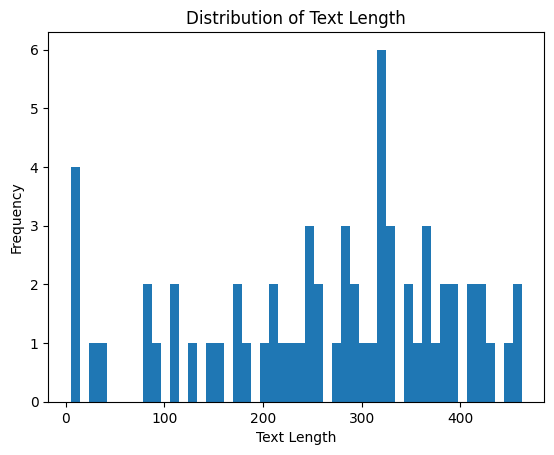

In [7]:
## Plot dist of text_length
ax = pdfs_data['Text_Length'].plot(kind='hist', bins=50, title='Distribution of Text Length')
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')

In [8]:
# Retain only the rows with a text length of at least 10

pdfs_data = pdfs_data.loc[pdfs_data['Text_Length'] >= 10]
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176


## Create metadata

In [9]:
# Store the metadata for each page in a separate column

pdfs_data['Metadata'] = pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


## Chunking and Embedding

In [10]:
# Set the API key
from dotenv import load_dotenv
load_dotenv("../.env")
import os
openai.api_key = os.environ.get("OPENAI_API_KEY")

In [11]:
# Define the path where chroma collections will be stored

chroma_data_path = '../ChromaDB'
# Call PersistentClient()

client = chromadb.PersistentClient(chroma_data_path)

In [12]:
# Define chunking method
def chunking(method: str):
    """return TextSplitter with one chunking method"""
    if method == 'RecursiveCharacterTextSplitter':
        return RecursiveCharacterTextSplitter(
            # Set a really small chunk size, just to show.
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
    elif method == 'CharacterTextSplitter':
        return CharacterTextSplitter(
            separator=" ",
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
            is_separator_regex=False,
        )
    else:
        raise ValueError(f"Unknown chunking method: {method}")

In [13]:
# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
collection = client.get_or_create_collection(name='RAG_HELPMATE', embedding_function=embedding_function)
# Initialise a chunking method
text_splitter = chunking(method='RecursiveCharacterTextSplitter')

In [14]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
documents_list = pdfs_data["Page_Text"].tolist()
metadata_list = pdfs_data['Metadata'].tolist()

In [15]:
documents = text_splitter.create_documents(
    documents_list, metadatas=metadata_list
)
documents[0]

Document(metadata={'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Page_No.': 'Page 1'}, page_content='DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014')

In [16]:
print(len(documents))
print(len(documents_list))

141
60


In [17]:
split_document_list = [doc.page_content for doc in documents]
split_metadata_list = [doc.metadata for doc in documents]


In [18]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.
collection.add(
    documents= split_document_list,
    ids = [str(i) for i in range(0, len(split_document_list))],
    metadatas = split_metadata_list
)

# Searching layer

## caching

In [19]:
# Implementing Cache in Semantic Search
class Caching():
  def __init__(self, collection):
    self.collection = collection
    self.cache_collection = client.get_or_create_collection(name='Cache', embedding_function=embedding_function)
    self.threshold = 0.2
    self.ids = []
    self.documents = []
    self.distances = []
    self.metadatas = []


  def search(self, query):
    cache_results = self.cache_collection.query(
        query_texts=query,
        n_results=1
    )
    # If the distance is greater than the threshold, then return the results from the main collection.
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > self.threshold:
          # Query the collection against the user query and return the top 10 results
          results = self.collection.query(
          query_texts=query,
          n_results=10
          )

          # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
          # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
          Keys = []
          Values = []

          for key, val in results.items():
            if val is None:
              continue
            for i in range(10):
              try:
                Keys.append(str(key)+str(i))
                Values.append(str(val[0][i]))
              except:
                 pass


          self.cache_collection.add(
              documents= [query],
              ids = [query], #[len(cache_results['documents'])],   # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
              metadatas = dict(zip(Keys, Values))
          )

          print("Not found in cache. Found in main collection.")

          result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
          results_df = pd.DataFrame.from_dict(result_dict)


    # If the distance is, however, less than the threshold, you can return the results from cache

    elif cache_results['distances'][0][0] <= self.threshold:
          cache_result_dict = cache_results['metadatas'][0][0]

          # Loop through each inner list and then through the dictionary
          for key, value in cache_result_dict.items():
              if 'ids' in key:
                  self.ids.append(value)
              elif 'documents' in key:
                  self.documents.append(value)
              elif 'distances' in key:
                  self.distances.append(value)
              elif 'metadatas' in key:
                  self.metadatas.append(value)

          print("Found in cache!")

          # Create a DataFrame
          results_df = pd.DataFrame({
            'IDs': self.ids,
            'Documents': self.documents,
            'Distances': self.distances,
            'Metadatas': self.metadatas
          })
    return results_df


In [20]:
# Initial the caching
cache = Caching(collection)

In [21]:
results_df = cache.search("What is the print date?")
results_df

Not found in cache. Found in main collection.


,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 15', 'Policy_Name': 'Princi...",A record which is on or transmitted by paper o...,0.452316,25
1,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",then been in force 24 months or more and if Wr...,0.488582,36
2,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",date Proof of Good Health is approved by The P...,0.495518,60
3,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Member for which Proof of Good Health is requi...,0.513354,61
4,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",the volume of insurance for then insured Membe...,0.521031,38
5,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,0.525071,37
6,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...",Scheduled Benefit amount because of a change i...,0.527073,58
7,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",may be started later than three years after th...,0.529750,140
8,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",under this Group Policy replaces coverage unde...,0.541384,52
9,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,0.542842,31


In [22]:
results_df = cache.search("when is the print date?")
results_df

Found in cache!


,IDs,Documents,Distances,Metadatas
0,25,A record which is on or transmitted by paper o...,0.4523160755634308,"{'Page_No.': 'Page 15', 'Policy_Name': 'Princi..."
1,36,then been in force 24 months or more and if Wr...,0.48858171701431274,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi..."
2,60,date Proof of Good Health is approved by The P...,0.49551770091056824,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."
3,61,Member for which Proof of Good Health is requi...,0.5133541226387024,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."
4,38,the volume of insurance for then insured Membe...,0.5210309624671936,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
5,37,b . on any date the definition of Member or De...,0.5250705480575562,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
6,58,Scheduled Benefit amount because of a change i...,0.5270731449127197,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi..."
7,140,may be started later than three years after th...,0.5297504386368884,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi..."
8,52,under this Group Policy replaces coverage unde...,0.5413839817047119,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi..."
9,31,c . a copy of the form which contains the stat...,0.5428417325019836,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi..."


## Re-ranker
- I use cross-encoder/ms-marco-MiniLM-L-6-v2 for cross_encoder and bi_encoder to compare the result from 2 methods

### Use CrossEncoder

In [23]:
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

/Users/cuong/anaconda3/envs/rag_helpmate/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])
scores

array([  3.8467636, -11.25288  ], dtype=float32)

### Use Bi-Encoder

In [25]:
# load model
# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("cross-encoder/ms-marco-MiniLM-L-6-v2")

sen1 = "Does the insurance cover diabetic patients?"
sen2 = "The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev"
em_sen1 = model.encode(sen1)
em_sen2 = model.encode(sen2)
score = model.similarity(em_sen1, [em_sen2,em_sen2])
np.array(score)[0]

No sentence-transformers model found with name cross-encoder/ms-marco-MiniLM-L-6-v2. Creating a new one with mean pooling.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/cuong/anaconda3/envs/rag_helpmate/lib/python3.10/site-packages/sentence_transformers/util.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  a = torch.tensor(a)


array([0.9598117, 0.9598117], dtype=float32)

### Implement 

In [26]:
# Implementing Cache with re-ranker in Semantic Search
class Caching():
  def __init__(self, collection):
    self.collection = collection
    self.cache_collection = client.get_or_create_collection(name='Cache', embedding_function=embedding_function)
    self.threshold = 0.2
    self.model_bi_encoder = SentenceTransformer("cross-encoder/ms-marco-MiniLM-L-6-v2")
    self.cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

  def bi_encoder(self, query, bi_input):
    em_query = model.encode(query)
    em_input = [model.encode(sen) for sen in bi_input]
    scores = model.similarity(em_query, em_input) 
    return np.array(scores)[0]
  
  def re_rank(self,rerank_method, query, results_df, top_k=-1): 
    # set return top reranked documents   
    # when top_k = -1, we just resort the searched output
    if top_k == -1 or top_k > len(results_df) :
       top_k = len(results_df)
    # rerank the result
    if rerank_method == "cross_encoder":
       cross_inputs  =  [[query, response] for response in results_df['Documents']]
       rerank_scores = self.cross_encoder.predict(cross_inputs)
    elif rerank_method == "bi_encoder":
       bi_input = [res for res in results_df["Documents"]]
       rerank_scores = self.bi_encoder(query, bi_input)
    else:
       rerank_scores = [0 for i in results_df['Documents']]
    results_df['Reranked_scores'] = rerank_scores
    results_df = results_df.sort_values(by="Reranked_scores", ascending=False)
    return results_df[:top_k]
       
  def search(self, query, top_k=4,rerank_method="cross_encoder"):
    # initial variables
    ids = []
    documents = []
    distances = []
    metadatas = []
    cache_results = self.cache_collection.query(
        query_texts=query,
        n_results=1
    )
    # If the distance is greater than the threshold, then return the results from the main collection.
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > self.threshold:
          # Query the collection against the user query and return the top 10 results
          results = self.collection.query(
          query_texts=query,
          n_results=10
          )

          # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
          # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
          Keys = []
          Values = []

          for key, val in results.items():
            if val is None:
              continue
            for i in range(10):
              try:
                Keys.append(str(key)+str(i))
                Values.append(str(val[0][i]))
              except:
                 pass


          self.cache_collection.add(
              documents= [query],
              ids = [query], #[len(cache_results['documents'])],   # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
              metadatas = dict(zip(Keys, Values))
          )

          print("Not found in cache. Found in main collection.")

          result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
          results_df = pd.DataFrame.from_dict(result_dict)


    # If the distance is, however, less than the threshold, you can return the results from cache

    elif cache_results['distances'][0][0] <= self.threshold:
          cache_result_dict = cache_results['metadatas'][0][0]

          # Loop through each inner list and then through the dictionary
          for key, value in cache_result_dict.items():
              if 'ids' in key:
                  ids.append(value)
              elif 'documents' in key:
                  documents.append(value)
              elif 'distances' in key:
                  distances.append(value)
              elif 'metadatas' in key:
                  metadatas.append(value)

          print("Found in cache!")

          # Create a DataFrame
          results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
          })
    # re rank the result 
    results_df = self.re_rank(rerank_method, query, results_df, top_k=top_k)

    return results_df


In [27]:
# Initial the caching
cache = Caching(collection, )

# the result with cross_encoder method
results_df = cache.search("when is the print date?", rerank_method="cross_encoder", top_k=-1)
results_df

No sentence-transformers model found with name cross-encoder/ms-marco-MiniLM-L-6-v2. Creating a new one with mean pooling.


Found in cache!


,IDs,Documents,Distances,Metadatas,Reranked_scores
1,36,then been in force 24 months or more and if Wr...,0.48858171701431274,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",-7.861535
4,38,the volume of insurance for then insured Membe...,0.5210309624671936,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-9.197831
3,61,Member for which Proof of Good Health is requi...,0.5133541226387024,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",-9.915037
5,37,b . on any date the definition of Member or De...,0.5250705480575562,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-9.931110
0,25,A record which is on or transmitted by paper o...,0.4523160755634308,"{'Page_No.': 'Page 15', 'Policy_Name': 'Princi...",-10.060886
2,60,date Proof of Good Health is approved by The P...,0.49551770091056824,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",-10.175892
6,58,Scheduled Benefit amount because of a change i...,0.5270731449127197,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...",-10.418126
8,52,under this Group Policy replaces coverage unde...,0.5413839817047119,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",-10.753594
7,140,may be started later than three years after th...,0.5297504386368884,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",-10.809189
9,31,c . a copy of the form which contains the stat...,0.5428417325019836,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",-11.288203


In [28]:
# the result with bi_encoder method

results_df = cache.search("when is the print date?", rerank_method="bi_encoder", top_k=-1)
results_df

Found in cache!


,IDs,Documents,Distances,Metadatas,Reranked_scores
0,25,A record which is on or transmitted by paper o...,0.4523160755634308,"{'Page_No.': 'Page 15', 'Policy_Name': 'Princi...",0.906830
7,140,may be started later than three years after th...,0.5297504386368884,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",0.853585
1,36,then been in force 24 months or more and if Wr...,0.48858171701431274,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",0.840227
8,52,under this Group Policy replaces coverage unde...,0.5413839817047119,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",0.781096
9,31,c . a copy of the form which contains the stat...,0.5428417325019836,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",0.637631
5,37,b . on any date the definition of Member or De...,0.5250705480575562,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",0.593535
3,61,Member for which Proof of Good Health is requi...,0.5133541226387024,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",0.549570
4,38,the volume of insurance for then insured Membe...,0.5210309624671936,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",0.511111
6,58,Scheduled Benefit amount because of a change i...,0.5270731449127197,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...",0.480931
2,60,date Proof of Good Health is approved by The P...,0.49551770091056824,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",0.334433


# Generative Layer

In [29]:
def generate_response(cache, query):
    results_df = cache.search(query, top_k=3)
    """ 
        Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{results_df}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]
    response = openai.chat.completions.create(
        model = 'gpt-3.5-turbo',
        messages= messages
    )
    return response.choices[0].message.content.split("\n")



In [30]:
query = "What is the printed date of life policy"
answer = generate_response(cache,  query)
print(answer)

Not found in cache. Found in main collection.
["The printed date of the life policy is not explicitly mentioned in the extracted documents provided. It's recommended to review the specific policy document related to the query for accurate details.", '', '---', '', 'Citations:', '1. Policy Name: Principal Life Policy', '   Page Number: Page 26', '', '2. Policy Name: Principal Life Policy', '   Page Number: Page 21', '', '3. Policy Name: Principal Life Insurance Company Policy', '   Page Number: Page 5']


# Query Search

# Generate the question
- Random 1 document from collection and based on this to generate the question
- Ask a "noise" question which is not in the document

In [31]:
# Define generate_question function
def generate_question(collection, documents):
    document = get_random_document(collection, documents)
    
    """ 
        Generate a question using GPT-3.5's ChatCompletion based on document.
    """
    messages = [
                {"role": "system", "content":  "You are a client in the insurance domain who can ask about insurance policies and documents."},
                {"role": "user", "content": f"""You are a client in the insurance domain who can ask about insurance policies and documents.
                                                Your task is generate the question from the provided document.
                                                Provided document: ### {document} ####
                                                """},
              ]
    response = openai.chat.completions.create(
        model = 'gpt-3.5-turbo',
        messages= messages
    )
    return response.choices[0].message.content,document

def get_random_document(collection,documents ):
    id = random.randint(0,len(documents))
    doc = collection.get(
        ids = [str(id)],
        include = ['documents', 'metadatas']
    )
    return doc['documents'][0]
 

In [32]:
question1, provided_document1 = generate_question(collection, documents)
print("Provided document:", "\n".join(provided_document1.split(".")))
print("Question:", "\n".join(question1.split(".")))

Provided document: date Proof of Good Health is approved by The Principal
 h
 Effective Date for Benefit Changes Due to Changes Requested by the Member (1) A change in a Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is not required (see e
 above) will normally be effective on the date of the request
 However, if the Member is not Actively at Work on the date a Scheduled Benefit change would otherwise be effective, the Scheduled Benefit change will not be in force until the date the Member returns to Active Work
 Any decrease in Scheduled Benefit amounts due to a request by the Member will be effective on the date of the change, whether or not the Member is Actively at Work
 (2) A change in the Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is required (see e
 above) will be effective on the later of: - the date the change would have been effective if Proof of Good Health had not b

In [33]:
question3, provided_document3 = generate_question(collection, documents)
print("Provided document:", "\n".join(provided_document3.split(".")))
print("Question:", "\n".join(question3.split(".")))

Provided document: otherwise be in force
 Neither will an error continue insurance that would otherwise be terminated
 The Principal may inspect, at any reasonable time, all Policyholder records, which relate to this Group Policy
 Article 7 - Certificates The Principal will give the Policyholder Certificates for delivery to insured Members
 The delivery of such Certificates will be in either paper or electronic format
 The Certificates will be evidence of insurance and will describe the basic features of the coverage
 They will not be considered a part of this Group Policy
 Article 8 - Assignments No assignments of Member Life Insurance will be allowed under this Group Policy
 Article 9 - Dependent Rights A Dependent will have no rights under this Group Policy except as set forth in PART III, Section F, Article 2
 Article 10 - Policy Interpretation This policy has been updated effective January 1, 2014 PART II - POLICY ADMINISTRATION GC 6003 Section A - Contract, Page 3
Question: From 

In [34]:
question4 = "What is RAG?"

## Query 1